In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack
from scipy.io import wavfile
import scipy.signal as signal
import rsa

## Encoding Functions

In [4]:
def audio_from_wav(filename):
    fs, data = wavfile.read(filename)
    print(type(data[0,0]))
    audio = (data[:,0] + data[:,1]) // 2
    data[:,0] = audio
    data[:,1] = audio
    wavfile.write("mono_of_" + filename, fs, data)
    return fs, audio;

def audio_to_wav(audio, filename, fs):
    data = np.zeros((len(audio), 2)).astype(np.int16)
    data[:,0] = audio
    data[:,1] = audio
    print(type(data[0,0]))
    wavfile.write(filename, fs, data)

def pad_audio(audio, fs, df):
    N = len(audio)
    N_min = fs/df
    N_req = int((N // N_min + 1) * N_min - N)
    pad = np.linspace(0, 0, N_req)
    audio = np.concatenate((audio, pad))
    return audio

def remove_low_frequencies(audio, fs, f_max):
    audio_fft = scipy.fftpack.rfft(audio)
    audio_fft[0:len(audio)*f_max*2//fs] = 0
    audio = np.real(scipy.fftpack.irfft(audio_fft))
    return audio

def add_data(audio, data, ampl, fs, df, f_min):
    f_data = np.linspace(f_min, f_min + (len(data)-1) * df, len(data))
    f_audio = np.fft.rfftfreq(len(audio), 1/fs)
    audio_fft = np.fft.rfft(audio)

    f_d = 0
    for f in range(len(f_audio)):
        if (f_data[f_d] >= f_audio[f]):
            audio_fft[f] = ampl * data[f_d]
            f_d += 1
            if f_d == len(f_data):
                break

    audio = np.real(np.fft.irfft(audio_fft))
    return audio

## Decoding Functions

In [ ]:
def recover_data(audio, data_ampl, data_len, fs, df, f_min):
    data = np.zeros(data_len)

    f_data = np.linspace(f_min, f_min + (len(data)-1) * df, len(data))
    f_audio = np.fft.rfftfreq(len(audio), 1/fs)
    audio_fft = np.fft.rfft(audio)

    f_d = 0
    for f in range(len(f_audio)):
        if (f_data[f_d] >= f_audio[f]):
            if (audio_fft[f] > data_ampl/2):
                data[f_d] = 1
            f_d += 1
            if f_d == len(f_data):
                break
    return data

## Encryption Functions

In [4]:
def create_keys(length):
    public_key, private_key = rsa.newkeys(length)

    with open('public_key.pem', 'wb') as f:
        f.write(public_key.save_pkcs1())
    
    with open('private_key.pem', 'wb') as f:
        f.write(private_key.save_pkcs1())
        
    return public_key, private_key

## Encryption tests

In [6]:
create_keys(100)

(PublicKey(813229623905027887006231241227, 65537),
 PrivateKey(813229623905027887006231241227, 65537, 74377807432239747870022695425, 6684914720049793, 121651458240139))

## Helper Functions

In [618]:
def plot_fft(audio, fs, f_max = 250):
    f_full = scipy.fftpack.rfftfreq(len(audio), 1/fs)
    audio_fft = scipy.fftpack.rfft(audio)
    plt.figure()
    plt.plot(f_full, np.abs(audio_fft))
    plt.xlim([0, f_max])
    plt.ylim([0, 1.5e7])
    plt.title('Song fft')

90
<class 'numpy.int16'>
<class 'numpy.int16'>
[0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0.
 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1.
 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1.
 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1.]


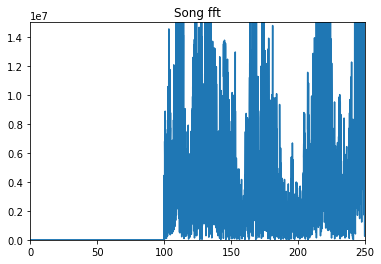

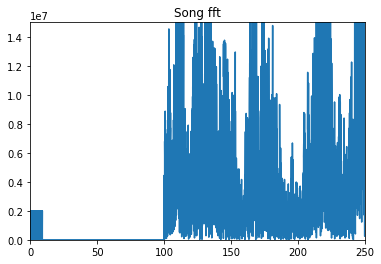

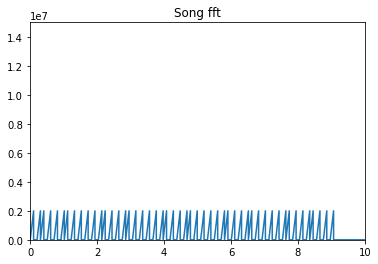

In [619]:
DELTA_FREQUENCIES = 0.1 # Hz
LOWEST_FREQUENCY = 1 # Hz
data = [0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1]
print(len(data))

fs, audio = audio_from_wav('bumblebee_small.wav')
pad_audio(audio, fs, DELTA_FREQUENCIES)
audio = remove_low_frequencies(audio, fs, 100)
plot_fft(audio, fs)
audio = add_data(audio, data, 0.2e7, fs, DELTA_FREQUENCIES, LOWEST_FREQUENCY)
plot_fft(audio, fs)
plot_fft(audio, fs, 10)
audio_to_wav(audio, 'bumblebee_small_with_data.wav', fs)

data_r = recover_data(audio, 0.2e7, len(data), fs, DELTA_FREQUENCIES, LOWEST_FREQUENCY)
print(data_r)
